In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import tqdm

pd.set_option("display.max_columns", None)
%matplotlib inline


In [2]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold

# Data Sampling & Splitting
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from utils import correlation


# Modelling
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Evaluation Metrics
from sklearn.metrics import confusion_matrix
from utils import make_confusion_matrix, plot_metrics, atomic_benchmark_estimator

# Model Export
import joblib


In [3]:
df = pd.read_csv("./data/Notebook 1 Data/data.csv")
report = pandas_profiling.ProfileReport(df, minimal=True)
df.head()


,id,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,score,class,time,period.name,start.time
0,1.0,3.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,3.0,15.0,3.0,2017-01-22 20:11:59,evening,2017-01-09 07:22:37
1,2.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,6.0,1.0,2017-02-08 22:53:06,evening,2017-01-09 07:22:37
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-02-08 08:00:46,morning,2017-01-09 07:22:37
3,4.0,2.0,1.0,1.0,2.0,0.0,0.0,2.0,3.0,0.0,3.0,14.0,2.0,2017-01-22 14:01:25,midday,2017-01-09 07:22:37
4,5.0,1.0,3.0,1.0,1.0,2.0,1.0,2.0,3.0,0.0,1.0,15.0,3.0,2017-01-21 15:37:24,midday,2017-01-09 07:22:37


# Data Analysis

## Perform Quick EDA

In [4]:
report.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


## Visualize Feature Relationship

### Score and class for every questions

<Figure size 720x432 with 0 Axes>

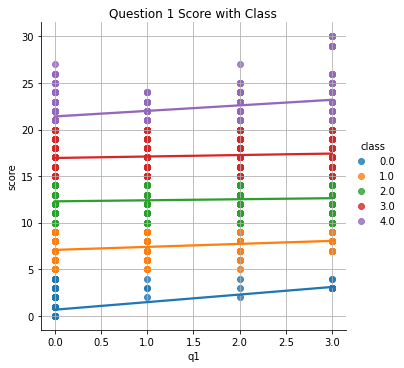

<Figure size 720x432 with 0 Axes>

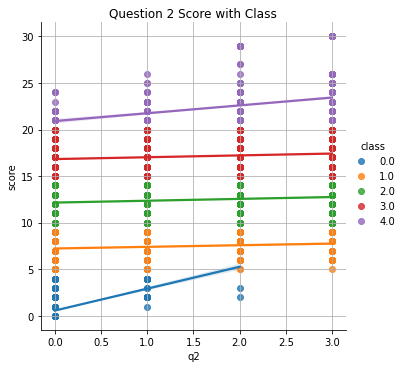

<Figure size 720x432 with 0 Axes>

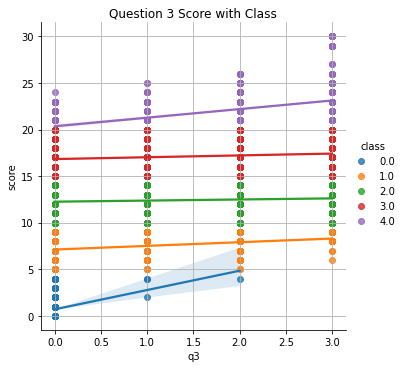

<Figure size 720x432 with 0 Axes>

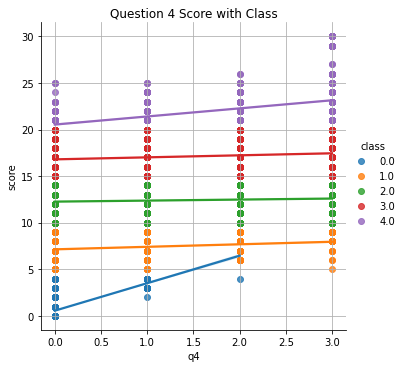

<Figure size 720x432 with 0 Axes>

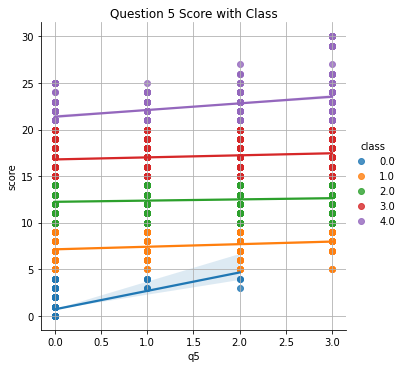

<Figure size 720x432 with 0 Axes>

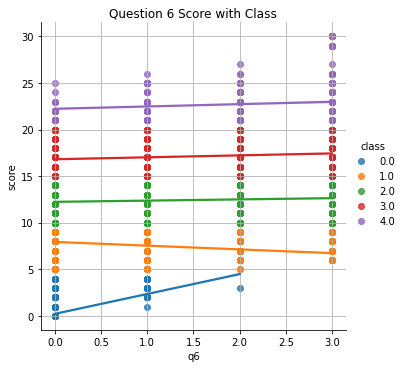

<Figure size 720x432 with 0 Axes>

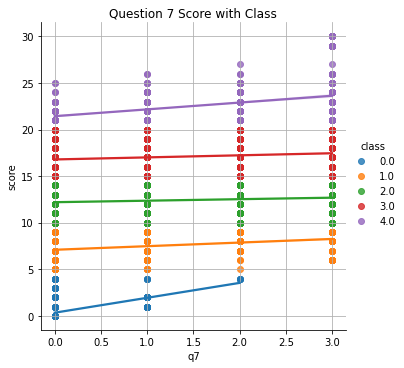

<Figure size 720x432 with 0 Axes>

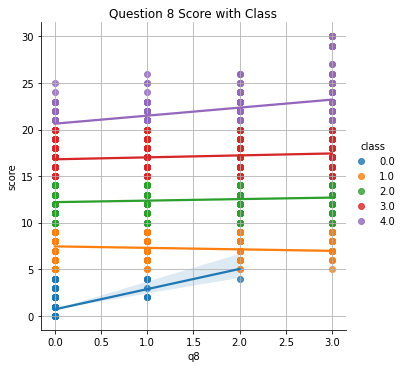

<Figure size 720x432 with 0 Axes>

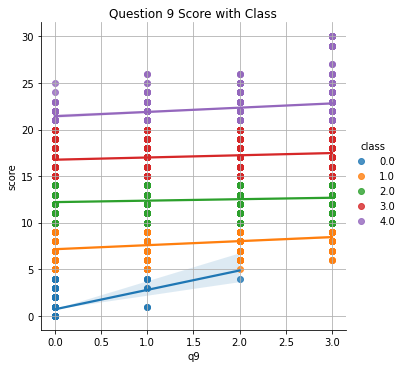

<Figure size 720x432 with 0 Axes>

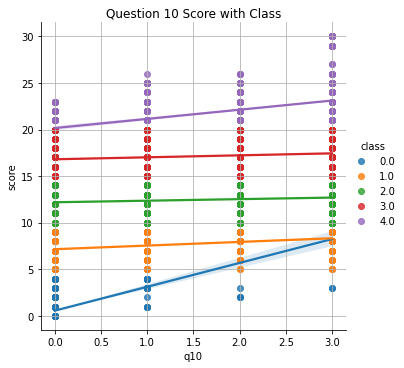

In [5]:
for i in range(1, 11):
    plt.figure(figsize=(10, 6))
    sns.lmplot(x=f"q{i}", y="score",
            data=df, hue="class")
    plt.title(f"Question {i} Score with Class")
    plt.grid()
    plt.show()


Findings:
1. score < 5: Normal / No Depression
2. 5 <= score < 10: Mild
3. 10 <= score < 15: Moderate
4. 15 <= score < 20: Severe
5. 20 <= score < 30: Extremely Severe
6. As compared to other questions, question 1 is the most not important/determining feature as all the lines is nearly straight horizontal.
7. Respondents who pick 3 (Nearly Every Day) from question 2 to 9 will suffer from mild depression to extremely severe depression. None of them is normal.

### Score for every time period

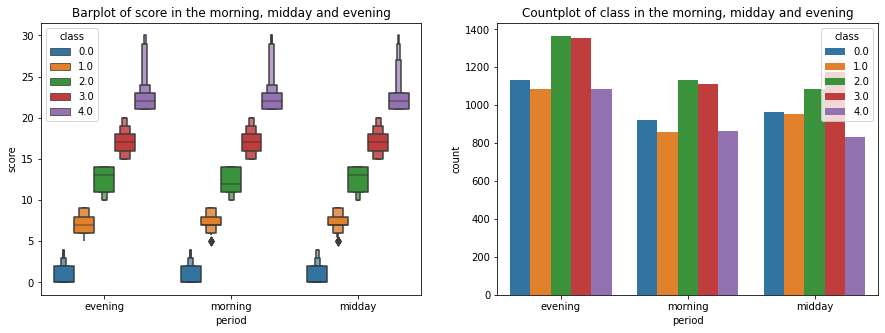

In [6]:
fig, (ax_bar, ax_reg) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxenplot(data=df, x="period.name", y="score", hue="class", ax=ax_bar)
sns.countplot(data=df, x="period.name", hue="class", ax=ax_reg)

ax_bar.set_title("Barplot of score in the morning, midday and evening")
ax_bar.set_xlabel("period")

ax_reg.set_title("Countplot of class in the morning, midday and evening")
ax_reg.set_xlabel("period")
plt.show()


Findings:
Most respondents answer the depression test on evening as compared to morning and midday.

Not much findings here, so we will drop the datetime features.

# Feature Engineering

## Handling Missing Values

From the quick EDA above, there's 227 missing records for all questions, I will assume that the 227 records are the same for each questions, so we will drop the missing values in the question column.

In [7]:
assert df.shape[0] - 227 == df.dropna(axis=0).shape[0]

Our hypothesis is correct, we have 227 missing records for all questions column and we will drop by using `pd.dropna` function and also since we have quite a lot of records in the dataset. 

In [8]:
df.dropna(axis=0, inplace=True)

After dropping the column let's visualize the class distribution after dropping the column.

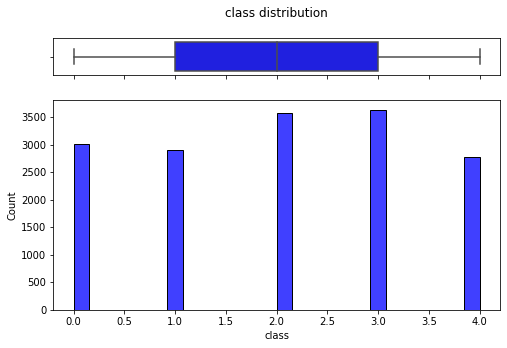

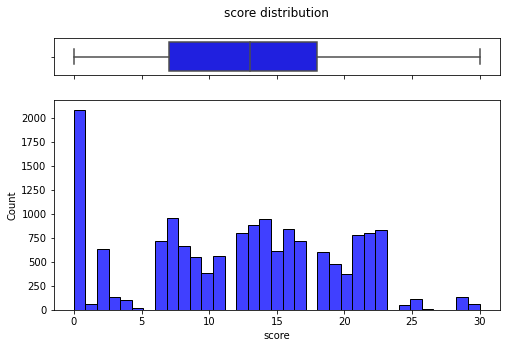

In [9]:
features = ["class", "score"]

for feature in features:
    _, (ax_box, _) = plt.subplots(2, sharex=True,
                                  gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8, 5))
    sns.boxplot(x=df[feature], ax=ax_box, color='b')
    sns.histplot(data=df, x=feature, color='b')
    ax_box.set(xlabel='')
    ax_box.set_title(f"{feature} distribution\n")
    plt.show()

The data is still distributed and there's no skewed data towards certain end. The dataset is beautiful and there's no outliers in the data.

The data is somehow clean and there's no further steps to perform in feature engineering sections

# Feature Selection

## Drop Unwanted Features

We will be dropping features column such as `id`, `time`, `period.name` and `start.time` as it doesn't affect directly to the results of our task.

One thing to point out is we also want to drop `score`, because we want our machine learning model to figure out the class by it's own without referring to the somehow label, `score` by its own.

In [10]:
df.drop(["id", "time", "period.name", "start.time", "score"], axis=1, inplace=True)

## Handling Constant Features

We will drop the constant features using variance threshold technique because there's no point using the features that are highly similar(or constant).

In [11]:
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(df)  # x features pd dataframe

var_thres.get_support()

constant_columns = [
    column for column in df.columns if column not in df.columns[var_thres.get_support()]]

constant_columns

[]

In [12]:
df.drop(constant_columns, axis=1, inplace=True)

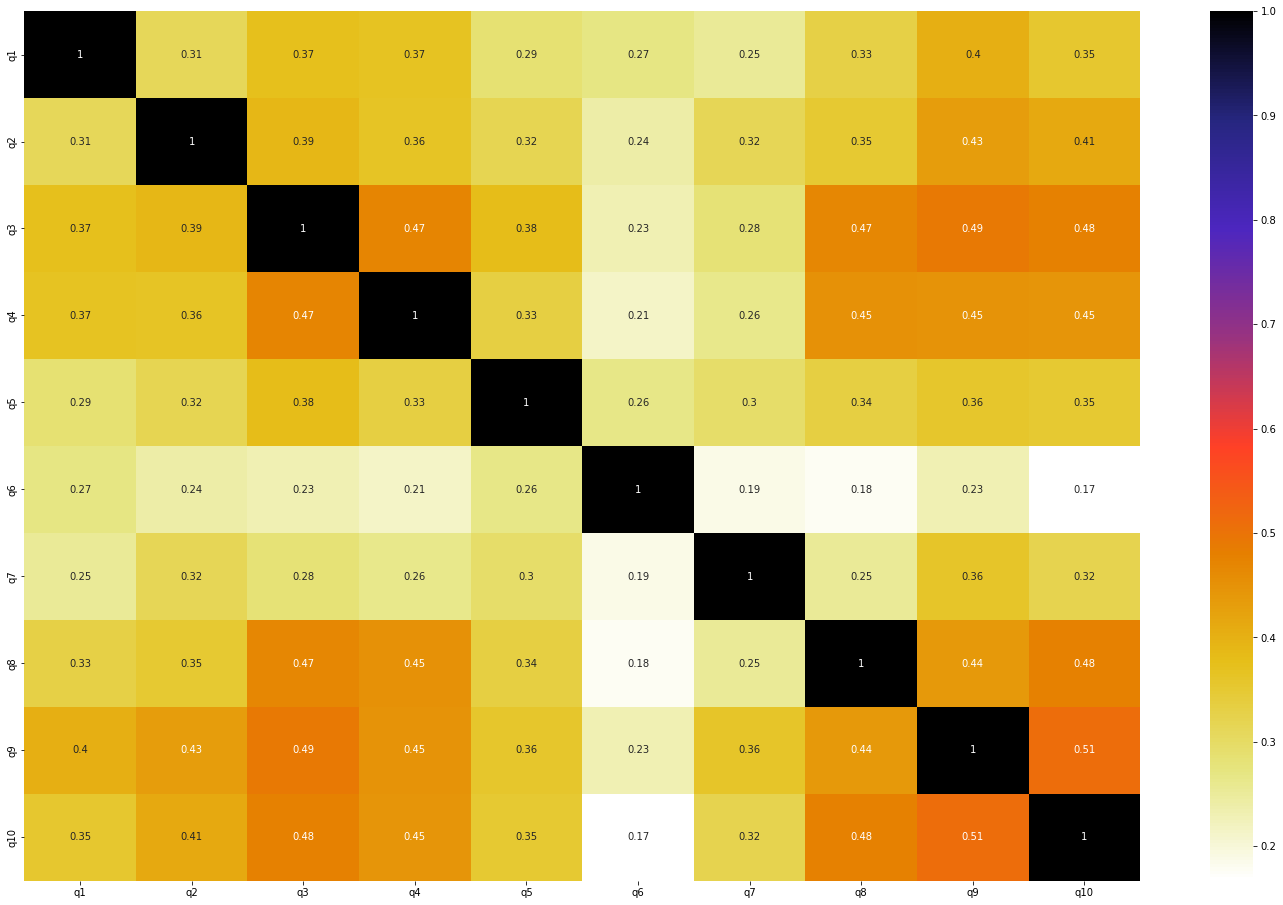

In [13]:
features = df.drop("class", axis=1)

# Visualize features correlation
plt.figure(figsize=(25, 16))
cor = features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [14]:
high_corr_columns = correlation(features, 0.95)
high_corr_columns

set()

In [15]:
df.drop(high_corr_columns, axis=1, inplace=True)

## Ranking Features Importance Using Information Gain

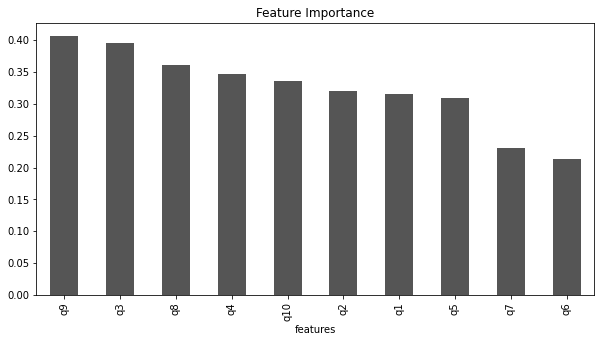

In [16]:
mutual_info = mutual_info_classif(features, df["class"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = features.columns

plt.figure(figsize=(10, 5))
mutual_info.sort_values(ascending=False).plot.bar(color="#555")
plt.title("Feature Importance")
plt.xticks(rotation=90)
plt.xlabel("features")
plt.show()

# Data Preparation

## Data splitting

In [17]:
target = df['class']
X_train, X_valid, y_train, y_valid = train_test_split(
    df, target, test_size=0.2, stratify=target, random_state=99)

X_train = X_train.drop(['class'], axis=1)
X_valid = X_valid.drop(['class'], axis=1)

In [18]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((12738, 10), (12738,), (3185, 10), (3185,))

## Data Normalization

In [19]:
normal_scaler = StandardScaler()

train_features = normal_scaler.fit_transform(X_train)
val_features = normal_scaler.transform(X_valid)

X_train_norm = np.clip(train_features, -5, 5)
X_valid_norm = np.clip(val_features, -5, 5)


print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_valid.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)

Training labels shape: (12738,)
Validation labels shape: (3185,)
Training features shape: (12738, 10)
Validation features shape: (3185, 10)


## Types of Data

In [20]:
X = {
    "train": X_train,
    "train_norm": X_train_norm,
    "valid": X_valid,
    "valid_norm": X_valid_norm,
}

## Load data into tensors

In [21]:
# Load un-normalized data into prefetched batch dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (X_valid, y_valid)).batch(128).prefetch(tf.data.AUTOTUNE)


# Load normalized data into prefetched batch dataset
train_dataset_norm = tf.data.Dataset.from_tensor_slices(
    (X_train_norm, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
valid_dataset_norm = tf.data.Dataset.from_tensor_slices(
    (X_valid_norm, y_valid)).batch(128).prefetch(tf.data.AUTOTUNE)

# Model Experiment

## Defining model evaluation metrics

### Confusion Matrix

In [22]:
labels = [
    'True Normal', 'False Mild', 'False Moderate', 'False Severe', 'False Extremely Severe',
    'False Normal', 'True Mild', 'False Moderate', 'False Severe', 'False Extremely Severe',
    'False Normal', 'False Mild', 'True Moderate', 'False Severe', 'False Extremely Severe',
    'False Normal', 'False Mild', 'False Moderate', 'True Severe', 'False Extremely Severe',
    'False Normal', 'False Mild', 'False Moderate', 'False Severe', 'True Extremely Severe',
]
categories = ['0', '1', '2', '3', '4']

### TensorFlow Model Metrics

In [23]:
METRICS = ["acc"]


## Model Formulation

Since we are dealing with multi-class classification problem, we will be using several machine learning algorithms:
1. Naive Bayes
2. K Nearest Neighbour
3. Support Vector Machine
4. Decision Tree
5. Random Forest
6. Neural Network

We will record all the experiment in the dictionary below. `[model, accuracy, time]`

In [24]:
models = {
    "sklearn": [],
    "tf": []
}

We will then compare and analyze every models at the end.

### Model 1 Naive Bayes

#### Naive Bayes With Unnormalized Data

In [25]:
gsnb_clf_1 = GaussianNB()
gsnb_clf_1.fit(X_train, y_train)

print("Naive Bayes Classifier No 1 trained successfully!")


Naive Bayes Classifier No 1 trained successfully!


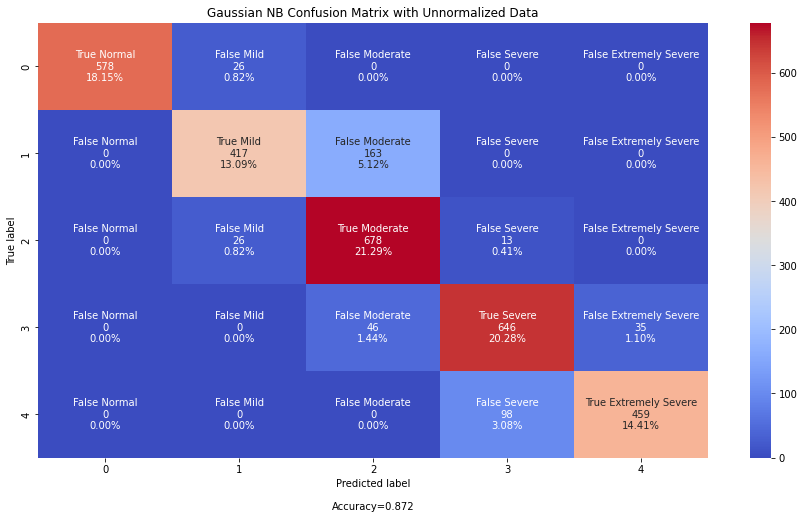

In [26]:
y_pred = gsnb_clf_1.predict(X_valid)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(gsnb_clf_1, X_valid)

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Gaussian NB Confusion Matrix with Unnormalized Data"
)

models["sklearn"].append((gsnb_clf_1, accuracy, runtimes))

#### Naive Bayes With Normalized Data

In [27]:
gsnb_clf_2 = GaussianNB()
gsnb_clf_2.fit(X_train_norm, y_train)

print("Naive Bayes Classifier No 2 trained successfully!")

Naive Bayes Classifier No 2 trained successfully!


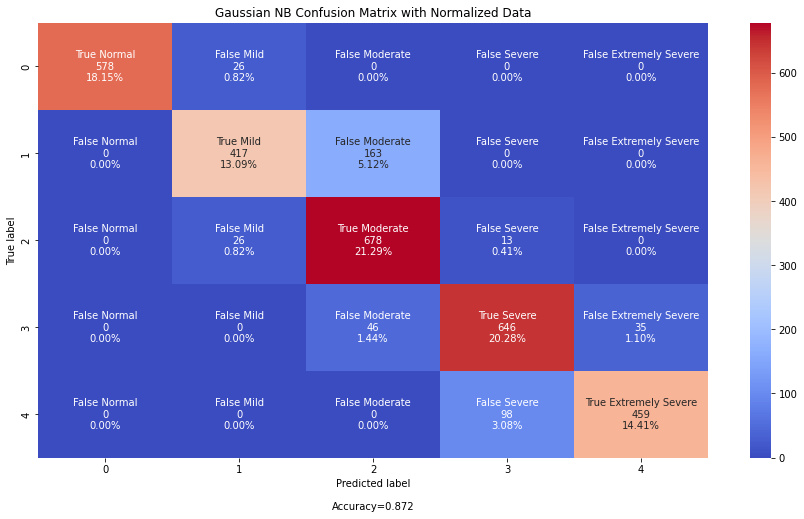

In [28]:
y_pred = gsnb_clf_2.predict(X_valid_norm)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(gsnb_clf_2, pd.DataFrame(X_valid_norm))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Gaussian NB Confusion Matrix with Normalized Data"
)

models["sklearn"].append((gsnb_clf_2, accuracy, runtimes))


Naive Bayes doesn’t require and is not affected by feature scaling.

In fact, any Algorithm which is NOT distance based, is not affected by Feature Scaling.

As Naive Bayes algorithm is based on probability not on distance, so it doesn’t require feature scaling.

### Model 2 K Nearest Neighbour

#### KNN With Unnormalized Data

In [29]:
knn_clf_1 = KNeighborsClassifier()
knn_clf_1.fit(X_train, y_train)

print("KNN Classifier No 1 trained successfully!")

KNN Classifier No 1 trained successfully!


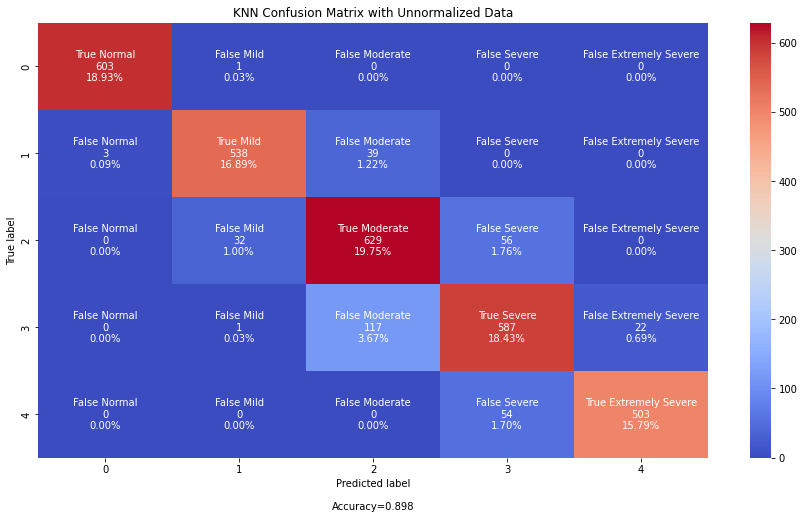

In [30]:
y_pred = knn_clf_1.predict(X_valid)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(knn_clf_1, X_valid)

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="KNN Confusion Matrix with Unnormalized Data"
)

models["sklearn"].append((knn_clf_1, accuracy, runtimes))

#### KNN With Normalized Data

In [31]:
knn_clf_2 = KNeighborsClassifier()
knn_clf_2.fit(X_train_norm, y_train)

print("KNN Classifier No 2 trained successfully!")

KNN Classifier No 2 trained successfully!


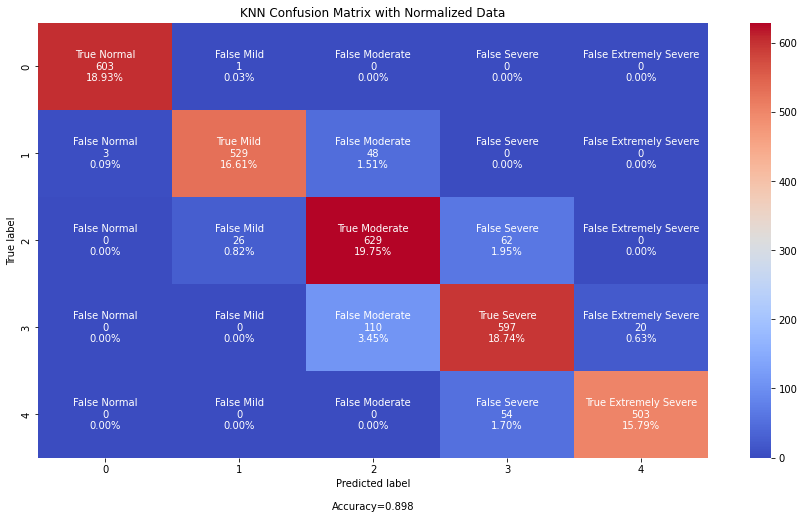

In [32]:
y_pred = knn_clf_2.predict(X_valid_norm)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(knn_clf_2, pd.DataFrame(X_valid_norm))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="KNN Confusion Matrix with Normalized Data"
)

models["sklearn"].append((knn_clf_2, accuracy, runtimes))

KNN get the accuracy of 0.898 and let's continue with svm.

### Model 3 Support Vector Machine

#### SVM With Unnormalized Data

In [33]:
svm_clf_1 = SVC()
svm_clf_1.fit(X_train, y_train)

print("SVM Classifier No 1 trained successfully!")

SVM Classifier No 1 trained successfully!


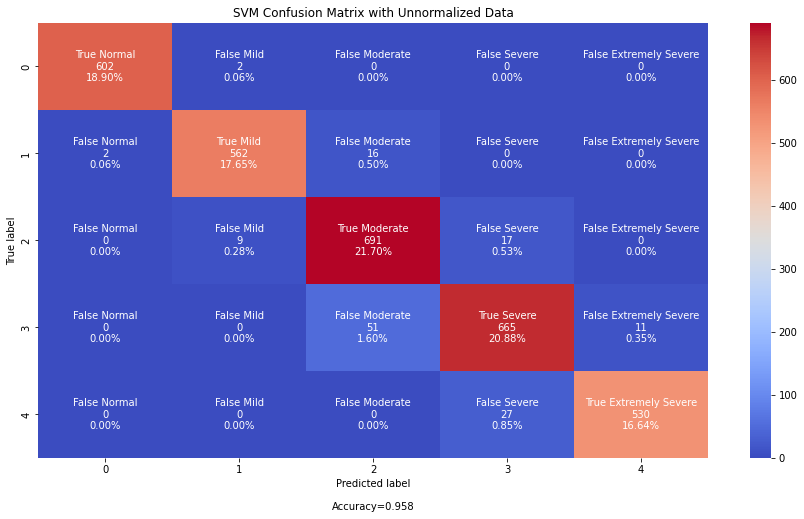

In [34]:
y_pred = svm_clf_1.predict(X_valid)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(svm_clf_1, X_valid)

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="SVM Confusion Matrix with Unnormalized Data"
)

models["sklearn"].append((svm_clf_1, accuracy, runtimes))


#### SVM With Normalized Data

In [35]:
svm_clf_2 = SVC()
svm_clf_2.fit(X_train_norm, y_train)

print("SVM Classifier No 2 trained successfully!")

SVM Classifier No 2 trained successfully!


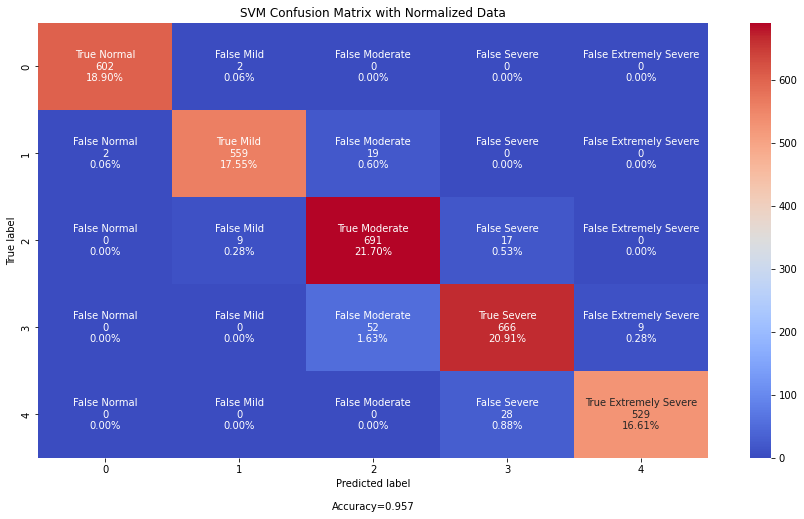

In [36]:
y_pred = svm_clf_2.predict(X_valid_norm)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(svm_clf_2, pd.DataFrame(X_valid_norm))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="SVM Confusion Matrix with Normalized Data"
)

models["sklearn"].append((svm_clf_2, accuracy, runtimes))

### Model 4 Decision Tree

#### Decision Tree With Unnormalized Data

In [37]:
dt_clf_1 = DecisionTreeClassifier()
dt_clf_1.fit(X_train, y_train)

print("Decision Tree Classifier No 1 trained successfully!")

Decision Tree Classifier No 1 trained successfully!


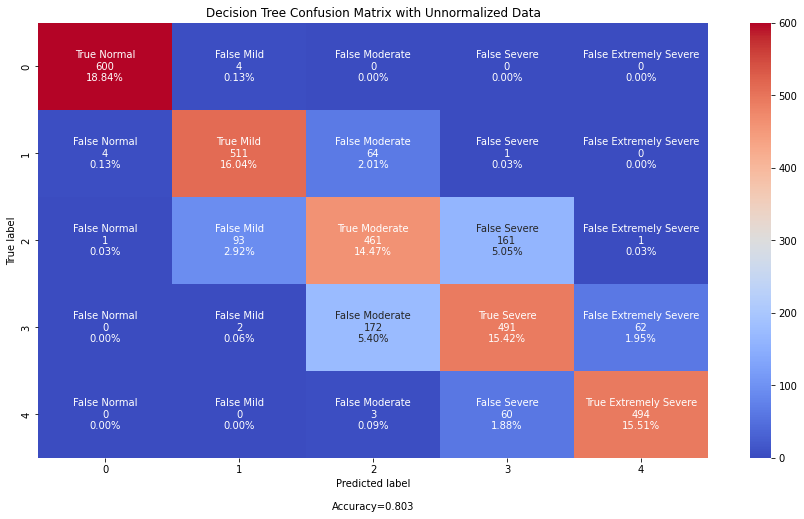

In [38]:
y_pred = dt_clf_1.predict(X_valid)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(dt_clf_1, X_valid)

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Decision Tree Confusion Matrix with Unnormalized Data"
)

models["sklearn"].append((dt_clf_1, accuracy, runtimes))

#### Decision Tree With Normalized Data

In [39]:
dt_clf_2 = DecisionTreeClassifier()
dt_clf_2.fit(X_train_norm, y_train)

print("Decision Tree Classifier No 2 trained successfully!")

Decision Tree Classifier No 2 trained successfully!


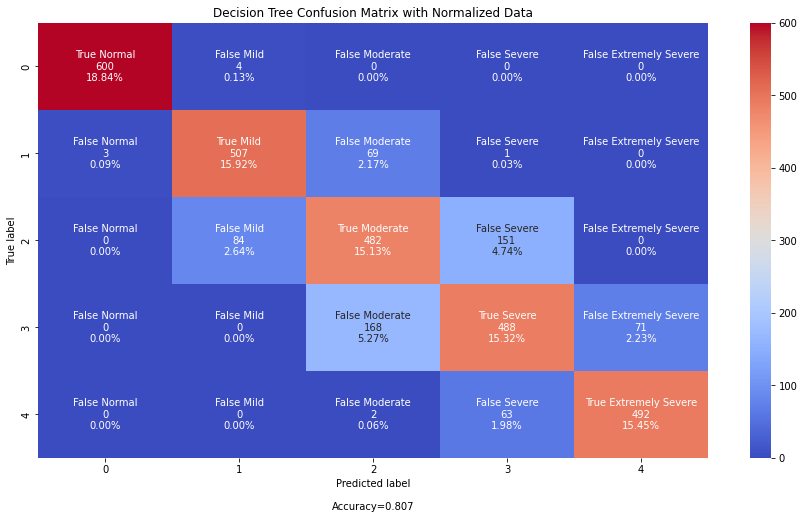

In [40]:
y_pred = dt_clf_2.predict(X_valid_norm)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(dt_clf_2, pd.DataFrame(X_valid_norm))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Decision Tree Confusion Matrix with Normalized Data"
)

models["sklearn"].append((dt_clf_2, accuracy, runtimes))


### Model 5 Random Forest

#### Random Forest With Unnormalized Data

In [41]:
rf_clf_1 = RandomForestClassifier()
rf_clf_1.fit(X_train, y_train)

print("Random Forest Classifier No 1 trained successfully!")

Random Forest Classifier No 1 trained successfully!


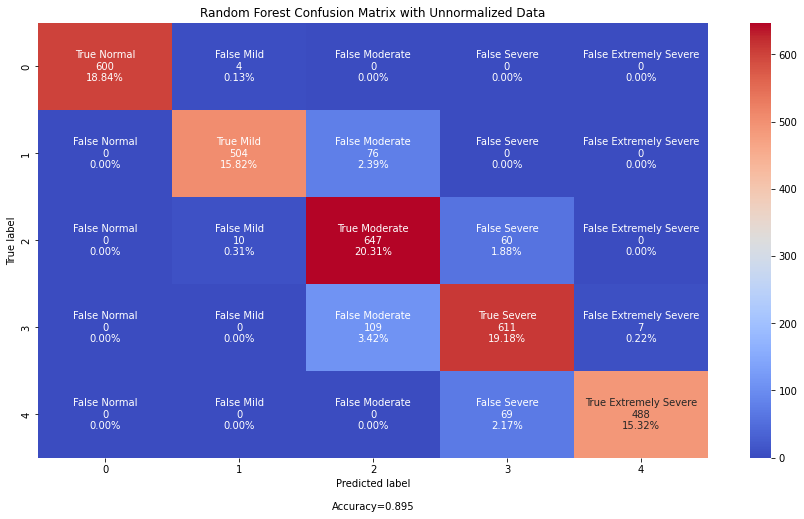

In [42]:
y_pred = rf_clf_1.predict(X_valid)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(rf_clf_1, X_valid)

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Random Forest Confusion Matrix with Unnormalized Data"
)

models["sklearn"].append((rf_clf_1, accuracy, runtimes))

#### Random Forest With Normalized Data

In [43]:
rf_clf_2 = RandomForestClassifier()
rf_clf_2.fit(X_train_norm, y_train)

print("Random Forest Classifier No 2 trained successfully!")


Random Forest Classifier No 2 trained successfully!


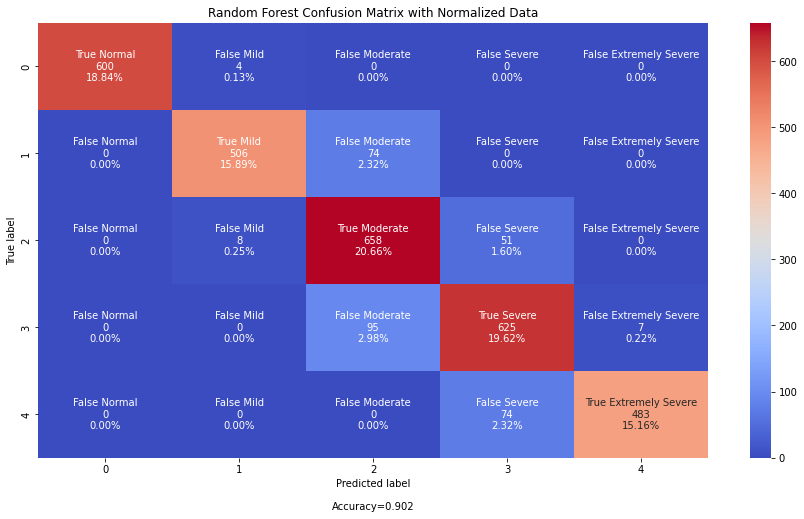

In [44]:
y_pred = rf_clf_2.predict(X_valid_norm)

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(rf_clf_2, pd.DataFrame(X_valid_norm))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Random Forest Confusion Matrix with Normalized Data"
)

models["sklearn"].append((rf_clf_2, accuracy, runtimes))

### Model 6 Neural Network

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='acc', patience=10, restore_best_weights=True, mode="max")

In [46]:
input = tf.keras.layers.Input(shape=(train_features.shape[-1], ))
x = tf.keras.layers.Dense(8, activation="relu")(input)
x = tf.keras.layers.Dense(8, activation="relu")(x)
output = tf.keras.layers.Dense(5, activation="softmax")(x)

nn_1 = tf.keras.Model(input, output)

nn_1.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=METRICS
)
# nn_1.summary()
history_1 = nn_1.fit(
    train_dataset_norm,
    epochs=100,
    validation_data=valid_dataset_norm,
    callbacks=[early_stopping],
    verbose=0
)

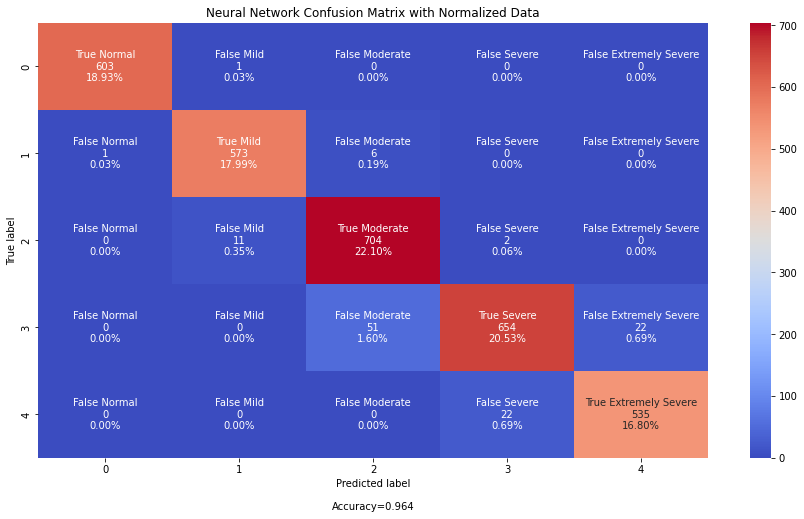

In [47]:
y_pred = nn_1.predict(X_valid_norm).squeeze()
y_pred = tf.argmax(tf.where(y_pred > 0.5, 1, 0), axis=1)
y_pred = y_pred.numpy()

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(nn_1, pd.DataFrame(X_valid_norm))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Neural Network Confusion Matrix with Normalized Data"
)

models["tf"].append((nn_1, accuracy, runtimes))


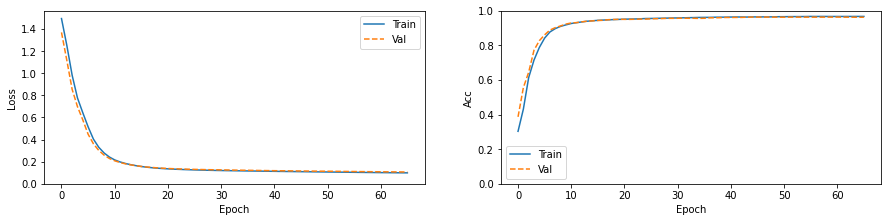

In [48]:
plt.figure(figsize=(15, 7))
plot_metrics(history_1)

# Model Evaluation

In [50]:
model_list = [(model, acc, run_time) for k in models.keys()
              for (model, acc, run_time) in models[k]]
model_df = pd.DataFrame(model_list, columns=["model", "accuracy", "time"])
model_df

,model,accuracy,time
0,GaussianNB(),0.872214,0.000949
1,GaussianNB(),0.872214,0.000910
2,KNeighborsClassifier(),0.897959,0.001273
3,KNeighborsClassifier(),0.898273,0.001372
4,SVC(),0.957614,0.001108
5,SVC(),0.956672,0.001092
6,DecisionTreeClassifier(),0.802826,0.000931
7,DecisionTreeClassifier(),0.806593,0.000774
8,"(DecisionTreeClassifier(max_features='sqrt', r...",0.894819,0.008478
9,"(DecisionTreeClassifier(max_features='sqrt', r...",0.901727,0.008595


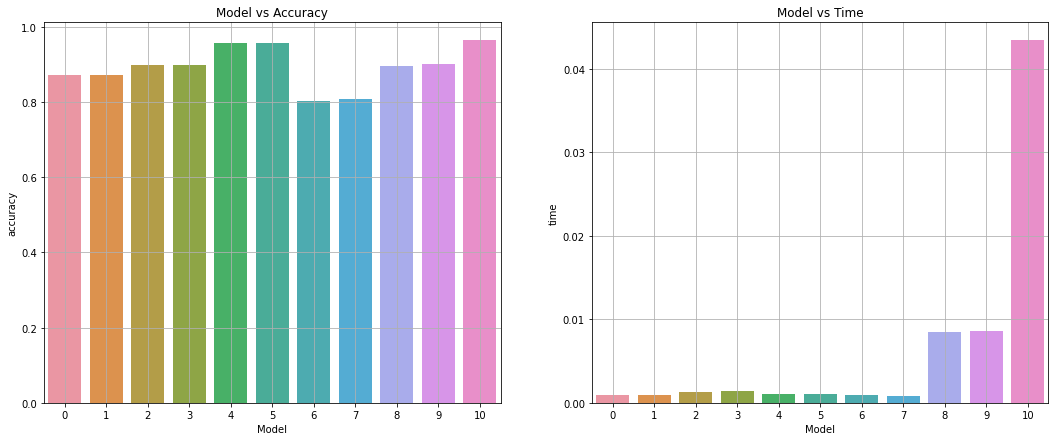

In [51]:
fig, (ax_acc, ax_time) = plt.subplots(1, 2, figsize=(18, 7))

ax_acc.set_title("Model vs Accuracy")
ax_acc.set_xlabel("Model")
sns.barplot(x=model_df.index, y="accuracy", data=model_df, ax=ax_acc)

ax_time.set_title("Model vs Time")
ax_time.set_xlabel("Model")
sns.barplot(x=model_df.index, y="time", data=model_df, ax=ax_time)

ax_acc.grid()
ax_time.grid()
plt.show()

In [52]:
model_df.sort_values("accuracy", ascending=False)

,model,accuracy,time
10,<keras.engine.functional.Functional object at ...,0.963579,0.043399
4,SVC(),0.957614,0.001108
5,SVC(),0.956672,0.001092
9,"(DecisionTreeClassifier(max_features='sqrt', r...",0.901727,0.008595
3,KNeighborsClassifier(),0.898273,0.001372
2,KNeighborsClassifier(),0.897959,0.001273
8,"(DecisionTreeClassifier(max_features='sqrt', r...",0.894819,0.008478
0,GaussianNB(),0.872214,0.000949
1,GaussianNB(),0.872214,0.000910
7,DecisionTreeClassifier(),0.806593,0.000774


In [53]:
model_df.sort_values("time", ascending=True)

,model,accuracy,time
7,DecisionTreeClassifier(),0.806593,0.000774
1,GaussianNB(),0.872214,0.000910
6,DecisionTreeClassifier(),0.802826,0.000931
0,GaussianNB(),0.872214,0.000949
5,SVC(),0.956672,0.001092
4,SVC(),0.957614,0.001108
2,KNeighborsClassifier(),0.897959,0.001273
3,KNeighborsClassifier(),0.898273,0.001372
8,"(DecisionTreeClassifier(max_features='sqrt', r...",0.894819,0.008478
9,"(DecisionTreeClassifier(max_features='sqrt', r...",0.901727,0.008595


This clearly shows the speed accuracy tradeoffs of the models.

# Model Export

We will be exporting:
1. Model Index 5 - Support Vector Classifier
2. Model Index 10 - Neural Network

In [57]:
!mkdir "model/Notebook 1/"

A subdirectory or file model/Notebook 2/ already exists.


In [60]:
joblib.dump(models["sklearn"][5][0], f'./model/Notebook 1/model_svc.joblib')

models["tf"][0][0].save(f"./model/Notebook 1/nn.h5")